In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

In [3]:
car_df = pd.read_csv('data.csv')

In [5]:
car_df.head()

,Unnamed: 0,image,classes
0,0,image/0.jpeg,unknown
1,1,image/1.jpeg,head_lamp
2,2,image/2.jpeg,door_scratch
3,3,image/3.jpeg,head_lamp
4,4,image/4.jpeg,unknown


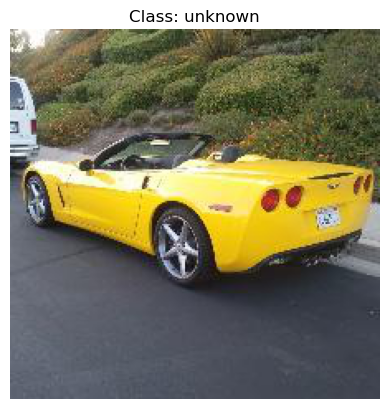

In [7]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt


# Pick a row, for example the second one
row = car_df.iloc[4]

# Full image path relative to current folder
img_path = row['image']  # e.g. "image/1.jpeg"

# Open and display the image
img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Class: {row['classes']}")

plt.show()


In [9]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1594 entries, 0 to 1593
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1594 non-null   int64 
 1   image       1594 non-null   object
 2   classes     1594 non-null   object
dtypes: int64(1), object(2)
memory usage: 37.5+ KB


In [11]:
car_df.groupby('classes').count()['image']

classes
bumper_dent       129
bumper_scratch    164
door_dent         192
door_scratch      154
glass_shatter     137
head_lamp         133
tail_lamp         136
unknown           549
Name: image, dtype: int64

/var/folders/bw/yb6dlzr14csbmrtjpf54bq6c0000gn/T/ipykernel_17414/1284369240.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


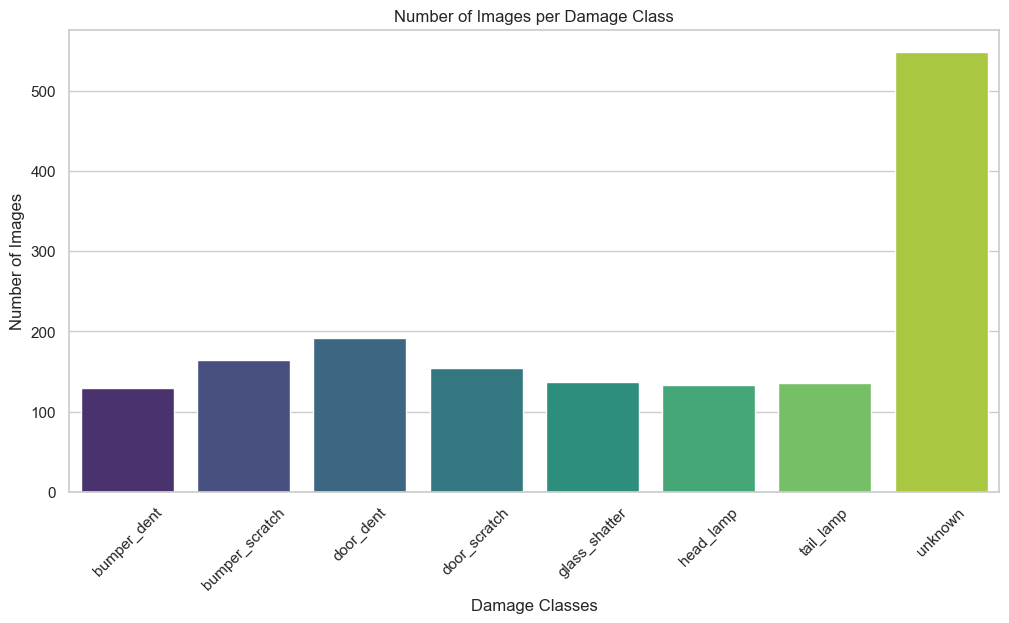

In [13]:
import seaborn as sns
class_counts = car_df.groupby('classes').count()['image']
sns.set(style="whitegrid")
plt.figure(figsize=(12,6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.xlabel('Damage Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images per Damage Class')
plt.xticks(rotation=45)
plt.show()

In [15]:
severity_map = {
    'head_lamp': 'moderate',
    'door_scratch': 'minor',
    'glass_shatter': 'severe',
    'unknown': 'no_damage',
    'bumper_dent':'moderate',
    'bumper_scratch':'minor',
    'door_dent':'moderate',
    'tail_lamp':'moderate'
}
car_df['Severity'] = car_df['classes'].map(severity_map)

In [17]:
car_df.head()

,Unnamed: 0,image,classes,Severity
0,0,image/0.jpeg,unknown,no_damage
1,1,image/1.jpeg,head_lamp,moderate
2,2,image/2.jpeg,door_scratch,minor
3,3,image/3.jpeg,head_lamp,moderate
4,4,image/4.jpeg,unknown,no_damage


In [19]:
def generate_cost(severity):
    if severity == 'minor':
        return np.random.randint(100,500)
    elif severity == 'moderate':
        return np.random.randint(500,1500)
    elif severity == 'severe':
        return np.random.randint(1500,3000)
    elif severity == 'no_damage':
        return 0
    else:
        return 0

car_df['Repair_cost'] = car_df['Severity'].apply(generate_cost)

In [21]:
car_df.head()

,Unnamed: 0,image,classes,Severity,Repair_cost
0,0,image/0.jpeg,unknown,no_damage,0
1,1,image/1.jpeg,head_lamp,moderate,1282
2,2,image/2.jpeg,door_scratch,minor,393
3,3,image/3.jpeg,head_lamp,moderate,745
4,4,image/4.jpeg,unknown,no_damage,0


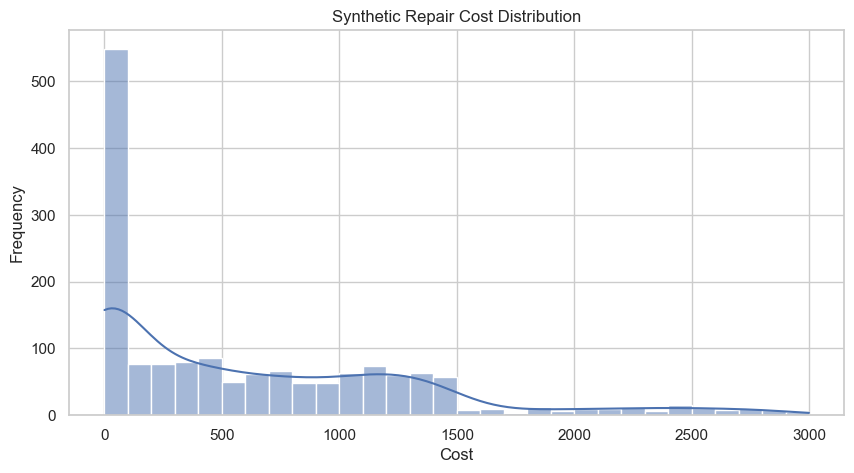

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.histplot(car_df['Repair_cost'], bins=30, kde=True)
plt.title('Synthetic Repair Cost Distribution')
plt.xlabel('Cost')
plt.ylabel('Frequency')
plt.show()

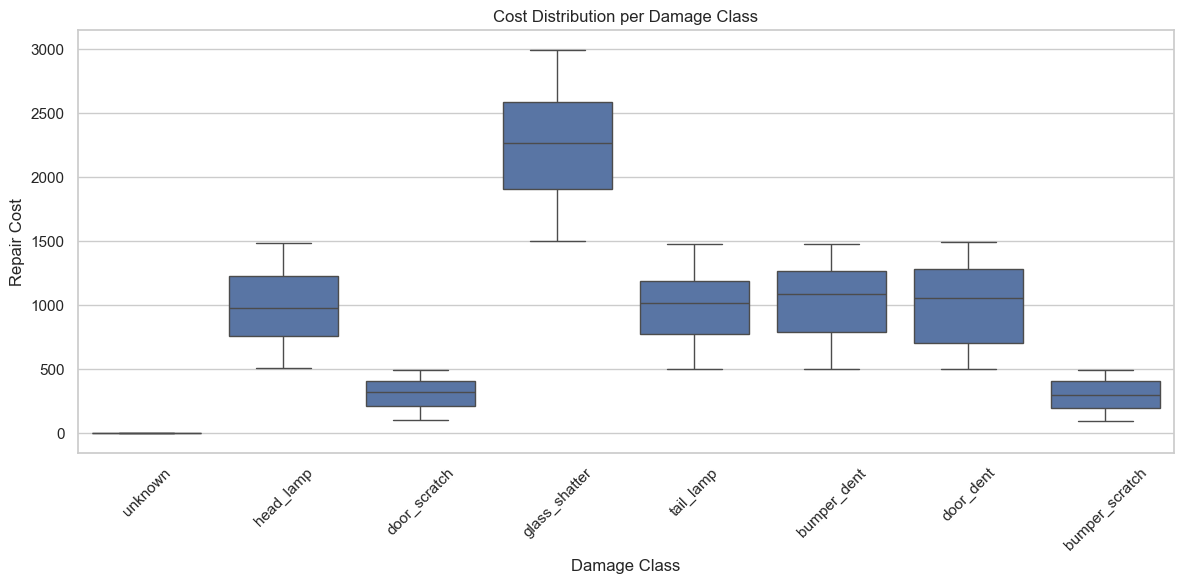

In [25]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='classes', y='Repair_cost', data=car_df)
plt.xticks(rotation=45)
plt.title('Cost Distribution per Damage Class')
plt.xlabel('Damage Class')
plt.ylabel('Repair Cost')
plt.tight_layout()
plt.show()

In [27]:
import os
from PIL import Image

# Paths
original_folder = 'image/'            # Your original images folder
resized_folder = 'image_resized/'    # Folder to save resized images

# Create resized folder if it doesn't exist
os.makedirs(resized_folder, exist_ok=True)

# Desired image size
target_size = (224, 224)

# Loop over all image files and resize
for filename in os.listdir(original_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(original_folder, filename)
        img = Image.open(img_path)
        img_resized = img.resize(target_size)
        save_path = os.path.join(resized_folder, filename)
        img_resized.save(save_path)

print(f"All images resized and saved to '{resized_folder}'")
car_df['image_resized'] = car_df['image'].apply(lambda x: x.replace('image/', 'image_resized/'))



All images resized and saved to 'image_resized/'


In [29]:
print(car_df['image_resized'].head())

0    image_resized/0.jpeg
1    image_resized/1.jpeg
2    image_resized/2.jpeg
3    image_resized/3.jpeg
4    image_resized/4.jpeg
Name: image_resized, dtype: object


In [31]:
import os

for img_path in car_df['image_resized'].head():
    print(img_path, os.path.exists(img_path))


image_resized/0.jpeg False
image_resized/1.jpeg True
image_resized/2.jpeg True
image_resized/3.jpeg True
image_resized/4.jpeg True


In [33]:
import os

# Keep only rows where the resized image file exists
car_df = car_df[car_df['image_resized'].apply(os.path.exists)].reset_index(drop=True)

print(car_df.head())

   Unnamed: 0         image       classes   Severity  Repair_cost  \
0           1  image/1.jpeg     head_lamp   moderate         1282   
1           2  image/2.jpeg  door_scratch      minor          393   
2           3  image/3.jpeg     head_lamp   moderate          745   
3           4  image/4.jpeg       unknown  no_damage            0   
4           5  image/5.jpeg       unknown  no_damage            0   

          image_resized  
0  image_resized/1.jpeg  
1  image_resized/2.jpeg  
2  image_resized/3.jpeg  
3  image_resized/4.jpeg  
4  image_resized/5.jpeg  


In [35]:
import tensorflow as tf

def preprocess(path, label):
    # Load image
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    
    # Normalize pixel values to [0, 1]
    img = tf.cast(img, tf.float32) / 255.0 
    return img, label

# Convert labels to integers if they are categorical
severity_to_int = {label: idx for idx, label in enumerate(car_df['Severity'].unique())}
car_df['severity_encoded'] = car_df['Severity'].map(severity_to_int)

# Create dataset
paths = car_df['image_resized'].values
labels = car_df['severity_encoded'].values

dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
dataset = dataset.map(preprocess).batch(32).shuffle(1000)

# Test a batch
for imgs, lbls in dataset.take(1):
    print(imgs.shape, lbls)
    

(32, 224, 224, 3) tf.Tensor([1 2 0 0 2 2 1 2 3 0 0 0 2 2 2 2 0 1 2 3 0 2 3 2 1 0 0 1 0 1 2 2], shape=(32,), dtype=int64)


2025-06-09 11:28:50.977047: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [37]:
car_df.head()

,Unnamed: 0,image,classes,Severity,Repair_cost,image_resized,severity_encoded
0,1,image/1.jpeg,head_lamp,moderate,1282,image_resized/1.jpeg,0
1,2,image/2.jpeg,door_scratch,minor,393,image_resized/2.jpeg,1
2,3,image/3.jpeg,head_lamp,moderate,745,image_resized/3.jpeg,0
3,4,image/4.jpeg,unknown,no_damage,0,image_resized/4.jpeg,2
4,5,image/5.jpeg,unknown,no_damage,0,image_resized/5.jpeg,2


In [39]:
from sklearn.model_selection import train_test_split

In [41]:
severity_to_int = {label: idx for idx, label in enumerate(car_df['Severity'].unique())}
num_classes = len(severity_to_int) # Get the number of unique severity classes
num_classes

4

In [43]:
# One-hot encode the labels
# First, get the integer encoded labels
car_df['severity_encoded_int'] = car_df['Severity'].map(severity_to_int)

# Then, convert to one-hot encoding
# Use tf.keras.utils.to_categorical
y_one_hot = tf.keras.utils.to_categorical(car_df['severity_encoded_int'], num_classes=num_classes)



In [45]:
# Now, split your data with the one-hot encoded labels
x = car_df['image_resized']
y = y_one_hot # Use the one-hot encoded labels here

In [47]:
X_train, X_val, y_train, y_val = train_test_split(
    x, y, test_size=0.2, stratify=car_df['severity_encoded_int'], random_state=42 # Stratify by the original integer labels
)

In [102]:
IMG_SIZE = 224
BATCH_SIZE = 32

from tensorflow.keras.applications.efficientnet import preprocess_input

def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = preprocess_input(image)  # automatically handles the correct normalization
    return image, label

def paths_labels_to_dataset(image_paths, labels):
    path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(labels, tf.float32)) 
    ds = tf.data.Dataset.zip((path_ds, label_ds))
    ds = ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = paths_labels_to_dataset(X_train, y_train)
val_ds = paths_labels_to_dataset(X_val, y_val)

# Test a batch to confirm shapes
for imgs, lbls in train_ds.take(1):
    print(f"Image batch shape: {imgs.shape}")
    print(f"Label batch shape (one-hot): {lbls.shape}") # Should be (BATCH_SIZE, num_classes)
    print(f"Sample label (one-hot): {lbls[0].numpy()}") # Should be like [0. 0. 1. 0.]

Image batch shape: (32, 224, 224, 3)
Label batch shape (one-hot): (32, 4)
Sample label (one-hot): [0. 1. 0. 0.]


In [104]:
# from tensorflow.keras import layers
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras import regularizers
# IMG_SIZE = 224

# # Data Augmentation Layer
# data_augmentation = tf.keras.Sequential([
#     layers.Rescaling(1./255),
#     layers.RandomFlip("horizontal"),
#     layers.RandomRotation(0.15),
#     layers.RandomZoom(0.1),
#     layers.RandomContrast(0.1),
# ])


# # Load base ResNet model
# base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
# base_model.trainable = False 

# # Define full model with augmentation
# inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
# x = data_augmentation(inputs)
# x = base_model(x, training=False)
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.5)(x)
# x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
# x = Dropout(0.5)(x)
# outputs = Dense(4, activation='softmax')(x) 

# model = Model(inputs, outputs)

# # Compile the model
# model.compile(
#     optimizer=Adam(learning_rate=0.001),
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# model.summary()

In [106]:
# history = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=10
# )

In [108]:
# loss, accuracy = model.evaluate(val_ds)

# print(f"Test Loss: {loss:.4f}")
# print(f"Test Accuracy: {accuracy:.4f}")

In [110]:
from tensorflow.keras.applications import EfficientNetB0
IMG_SIZE = 224 
data_augmentation1 = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),         
    layers.RandomZoom(0.2),             
    layers.RandomContrast(0.2),         
    layers.RandomTranslation(height_factor=0.15, width_factor=0.15), 
    layers.RandomBrightness(factor=0.2), 
], name="data_augmentation_layer") 


base_model1 = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3)) # ADD THIS LINE
base_model1.trainable = False # Freeze the base model for now

In [112]:
from tensorflow.keras import regularizers
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import Precision, Recall

inputs_1 = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x_1 = data_augmentation1(inputs_1) 
x_1 = base_model1(inputs_1, training=False)
x_1 = GlobalAveragePooling2D()(x_1)
x_1 = Dropout(0.5)(x_1)
x_1 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x_1)
x_1 = Dropout(0.5)(x_1)
outputs_1 = Dense(4, activation='softmax')(x_1) 
model_1 = Model(inputs_1, outputs_1)



class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(car_df['severity_encoded_int']),
    y=car_df['severity_encoded_int']
)
class_weights = dict(enumerate(class_weights))
model_1.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

history_1 = model_1.fit(
    train_ds,
    validation_data=val_ds,
    class_weight=class_weights,
    epochs=10 ,
    
)

Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 396ms/step - accuracy: 0.2709 - loss: 1.7702 - precision_2: 0.2774 - recall_2: 0.0986 - val_accuracy: 0.2966 - val_loss: 1.6149 - val_precision_2: 0.3750 - val_recall_2: 0.0103
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 376ms/step - accuracy: 0.2408 - loss: 1.7916 - precision_2: 0.2480 - recall_2: 0.0810 - val_accuracy: 0.3414 - val_loss: 1.5822 - val_precision_2: 0.4286 - val_recall_2: 0.0103
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 372ms/step - accuracy: 0.2720 - loss: 1.7754 - precision_2: 0.2787 - recall_2: 0.0979 - val_accuracy: 0.3862 - val_loss: 1.5539 - val_precision_2: 0.4286 - val_recall_2: 0.0103
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 378ms/step - accuracy: 0.3141 - loss: 1.6877 - precision_2: 0.3705 - recall_2: 0.1194 - val_accuracy: 0.4241 - val_loss: 1.5268 - val_precision_2: 0.5714 - val_recall_2: 0.0138
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 374ms/step - accuracy: 0.3130 - loss: 1.7634 - precision_2: 0.2672 - recall_2: 0.0

In [90]:
import numpy as np
print("Train class distribution:", np.sum(y_train, axis=0))
print("Val class distribution:", np.sum(y_val, axis=0))


Train class distribution: [431. 234. 396.  99.]
Val class distribution: [108.  58.  99.  25.]


In [114]:
for images, labels in train_ds.take(1):
    print("Images batch shape:", images.shape)          # Expect (batch_size, IMG_SIZE, IMG_SIZE, 3)
    print("Labels batch shape:", labels.shape)          # Expect (batch_size, num_classes)
    print("Sample labels (one-hot vectors):")
    print(labels.numpy()[:5])                            # Print first 5 labels in the batch
    print("Sum per label (should be 1.0 for one-hot):")
    print(labels.numpy()[:5].sum(axis=1))

Images batch shape: (32, 224, 224, 3)
Labels batch shape: (32, 4)
Sample labels (one-hot vectors):
[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]
Sum per label (should be 1.0 for one-hot):
[1. 1. 1. 1. 1.]


In [116]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.array([0, 1, 2, 3])
train_labels = np.argmax(y_train, axis=1)  # from one-hot to class indices
class_weights = compute_class_weight('balanced', classes=classes, y=train_labels)
class_weight_dict = dict(zip(classes, class_weights))
print(class_weight_dict)

{0: 0.6728538283062645, 1: 1.2393162393162394, 2: 0.7323232323232324, 3: 2.9292929292929295}


In [118]:
from sklearn.preprocessing import StandardScaler

# For features and target
x_scaler = StandardScaler()
y_scaler = StandardScaler()

In [120]:
x1 = car_df['image_resized'].values
y1 = car_df['Repair_cost'].values.astype(np.float32)

In [122]:
X1_train, X1_val, y1_train, y1_val = train_test_split(
    x1, y1, test_size=0.2, random_state=42
)
from sklearn.preprocessing import StandardScaler

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y1_train.reshape(-1, 1))
y_val_scaled = y_scaler.transform(y1_val.reshape(-1, 1))

In [124]:
def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = image / 255.0
    return image, label

def paths_labels_to_dataset(image_paths, labels):
    path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    ds = tf.data.Dataset.zip((path_ds, label_ds))
    ds = ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = paths_labels_to_dataset(X1_train, y_train_scaled)
val_ds = paths_labels_to_dataset(X1_val, y_val_scaled)


In [126]:
from tensorflow.keras import regularizers
from tensorflow.keras.applications import EfficientNetB0
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)


x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)  
x = Dropout(0.5)(x)

outputs = Dense(1, activation='linear', kernel_regularizer=regularizers.l2(0.001))(x)  

model = Model(inputs, outputs)

model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
model.summary()


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [128]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',    
    patience=7,            
    restore_best_weights=True  
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks= [early_stop,reduce_lr]
)

Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 435ms/step - loss: 1.3565 - mae: 0.8551 - val_loss: 1.2881 - val_mae: 0.8473 - learning_rate: 0.0010
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 411ms/step - loss: 1.2374 - mae: 0.8294 - val_loss: 1.2742 - val_mae: 0.8558 - learning_rate: 0.0010
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 405ms/step - loss: 1.1908 - mae: 0.8138 - val_loss: 1.2729 - val_mae: 0.8753 - learning_rate: 0.0010
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 404ms/step - loss: 1.1403 - mae: 0.7928 - val_loss: 1.2457 - val_mae: 0.8558 - learning_rate: 0.0010
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 401ms/step - loss: 1.1430 - mae: 0.8026 - val_loss: 1.2362 - val_mae: 0.8619 - learning_rate: 0.0010
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 412ms/step - loss: 1.1985 - mae: 0.8378 - val_loss: 1.2248 - val_mae: 0.8612 - learning_rate: 0.0010
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 410ms/step - loss: 1.1724 - mae: 0.8215 - val_loss: 1.2165 - val_mae: 0.8279 - learning_rate: 0.0010

In [129]:

loss, accuracy = model.evaluate(val_ds)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 271ms/step - loss: 1.1567 - mae: 0.8314
Test Loss: 1.1837
Test Accuracy: 0.8401
